<a href="https://colab.research.google.com/github/ragabhumi/Praktikum_Magnetbumi_STMKG/blob/main/Pengolahan_Data_Magnetbumi_Survey_Lapangan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PENGOLAHAN DATA MAGNET BUMI - 2024**

**Pengolahan Data Magnet Bumi menggunakan Data Survey**

oleh: Yosi Setiawan

Tangerang Selatan, 28 April 2024

Pada praktik pengolahan data magnet bumi ini, software yang digunakan adalah Fatiando a Terra (Uieda et.al., 2013) untuk analisis data magnet bumi, dan PyGMT (Uieda et.al., 2023) untuk visualisasi yang keduanya berbasis Python. Pengolahan dilakukan di Google Colab untuk memudahkan akses terhadap program dan data yang digunakan tanpa harus menginstall di komputer atau laptop masing-masing peserta.

Pada bagian ini, data yang akan digunakan adalah **data hasil survey magnet bumi** di wilayah Pelabuhanratu pada tahun 2022.

Langkah pertama yang harus dilakukan adalah menginstal CondaColab di Google Colab di akun Google masing-masing. Tekan tombol **Run cell** di sebelah kiri setiap cell atau tekan tombol Ctrl+Enter. Tunggu hingga proses instalasi selesai. Jika muncul notifikasi **Your session crashed for an unknown reason.**, abaikan dan tutup notifikasi tersebut.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Selanjutnya, cek apakah instalasi CondaColab telah berhasil. Pastikan hasil yang muncul adalah **Everything looks OK!**.

In [ ]:
import condacolab
condacolab.check()

Langkah berikutnya adalah menginstal modul-modul Python yang diperlukan. Proses ini memerlukan waktu yang agak lama. Tunggulah hingga proses selesai.

In [ ]:
!mamba install verde harmonica boule pooch pygmt pandas xarray pyigrf xrft rioxarray ensaio pyproj

Import modul-modul Python yang akan digunakan


In [3]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xrft
import datetime
from scipy import signal

# For IGRF correction
import pyIGRF

# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

Data survey magnet bumi yang akan digunakan dalam pelatihan ini telah diupload di Github. Untuk mengunduhnya kita gunakan modul Pooch.

In [ ]:
url_mag = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi_STMKG/main/data/data_survey.txt'
sha='sha256:98082e487f642b0ed36e1a4fd1bacff1cf53905154b93811a910b3f1cc05715e'
path_mag = pooch.retrieve(url_mag, known_hash=sha)
print(path_mag)

Data survey yang telah didownload formatnya adalah txt dan harus diparsing atau ditentukan identitas tiap kolomnya. Khusus untuk kolom yang menunjukkan waktu, ditambahkan perintah agar kolom tersebut terbaca sebagai variabel datetime.

In [ ]:
data = pd.read_csv(path_mag, sep='\t')
data['Waktu1'] = pd.to_datetime(data['Waktu1'], format='%Y-%m-%d %H:%M:%S')
data['Waktu2'] = pd.to_datetime(data['Waktu2'], format='%Y-%m-%d %H:%M:%S')
data['Waktu3'] = pd.to_datetime(data['Waktu3'], format='%Y-%m-%d %H:%M:%S')

data

Karena data di tiap titik survey masing-masing dilakukan sebanyak tiga kali pembacaan, kita hitung rata-rata waktu dan rata-rata nilai pembacaan proton dari ketiga pembacaan tersebut.

In [ ]:
data['Waktu_rata'] = data.loc[:, ['Waktu1', 'Waktu2', 'Waktu3']].mean(axis=1).dt.strftime('%Y-%m-%d %H:%M:%S')
data['F_rata'] = data.loc[:, ['F1', 'F2', 'F3']].mean(axis=1).map('{:.2f}'.format)
data

Untuk menampilkan titik-titik lokasi survey, kita buat peta menggunakan modul PyGMT. Variabel **region** menunjukkan batas koordinat lokasi dengan urutan kiri, kanan, bawah, dan atas peta.

In [ ]:
fig = pygmt.Figure()
fig.basemap(projection='x1:2000', region=[672480, 672850, 9225140, 9225530], frame=True)
fig.plot(x=data['Longitude'], y=data['Latitude'],
    style="c0.20c",
    fill="red",
    pen="faint")
fig.show()

Selanjutnya, kita import data proton base station yang juga telah diupload di Github. Survey magnet bumi ini dilakukan selama 4 hari, sehingga data proton base station juga sebanyak 4 file.

In [ ]:
# Base station hari 1
url_base = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi_STMKG/main/data/proton_base_20-04-2022.txt'
sha ='sha256:bb7f245ef8d0e3f1b9ec0e061cd1413e5b6557508a40d5392960dd014cd1ae7b'
base_day1 = pooch.retrieve(url_base, known_hash=sha)
print(base_day1)

# Base station hari 2
url_base = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi_STMKG/main/data/proton_base_21-04-2022.txt'
sha ='sha256:f4af8f4db524bc21494087bbba540141168388e506de4616341ddb6ba53eda61'
base_day2 = pooch.retrieve(url_base, known_hash=sha)
print(base_day2)

# Base station hari 3
url_base = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi_STMKG/main/data/proton_base_22-04-2022.txt'
sha ='sha256:6bd280b081841396114c092c5e5004efc7888031e4ba3fa33449f5c7a3c38403'
base_day3 = pooch.retrieve(url_base, known_hash=sha)
print(base_day3)

# Base station hari 4
url_base = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi_STMKG/main/data/proton_base_23-04-2022.txt'
sha ='sha256:cb17d1b0a88143a5767eae201288cd46335b890f0be264135e61f4d27cc58ff4'
base_day4 = pooch.retrieve(url_base, known_hash=sha)
print(base_day4)

# Base station hari 5
url_base = 'https://raw.githubusercontent.com/ragabhumi/Praktikum_Magnetbumi_STMKG/main/data/proton_base_24-04-2022.txt'
sha ='sha256:28421c6869802d7d49fee951c6a082d95e76dbf1a9eaf4a9a7ad139066214796'
base_day5 = pooch.retrieve(url_base, known_hash=sha)
print(base_day5)

Data proton base station yang telah didownload, selanjutnya diparsing menggunakan modul Pandas. Seperti sebelumnya, khusus untuk kolom yang menunjukkan waktu, ditambahkan perintah agar kolom tersebut terbaca sebagai variabel datetime.

In [ ]:
base1 = pd.read_csv(base_day1, sep='\t', names=['Waktu', 'Fbase'])
base2 = pd.read_csv(base_day2, sep='\t', names=['Waktu', 'Fbase'])
base3 = pd.read_csv(base_day3, sep='\t', names=['Waktu', 'Fbase'])
base4 = pd.read_csv(base_day4, sep='\t', names=['Waktu', 'Fbase'])
base5 = pd.read_csv(base_day5, sep='\t', names=['Waktu', 'Fbase'])

base1['Waktu'] = pd.to_datetime(base1['Waktu'], format='%Y-%m-%d %H:%M:%S')
base2['Waktu'] = pd.to_datetime(base2['Waktu'], format='%Y-%m-%d %H:%M:%S')
base3['Waktu'] = pd.to_datetime(base3['Waktu'], format='%Y-%m-%d %H:%M:%S')
base4['Waktu'] = pd.to_datetime(base4['Waktu'], format='%Y-%m-%d %H:%M:%S')
base5['Waktu'] = pd.to_datetime(base5['Waktu'], format='%Y-%m-%d %H:%M:%S')

base1

Selanjutnya kita gabungkan data proton base station menjadi satu variabel

In [ ]:
base = pd.concat([base1, base2, base3, base4, base5]).reset_index(drop=True)
base

Tampilkan grafik variasi harian dari data proton base station yang telah digabungkan.

In [ ]:
fig = pygmt.Figure()
# create a basemap with limits of 2022-04-21 to 2022-04-24 on the x axis and
# 45200 to 45400 on the y axis
fig.basemap(
    projection="X25c/15c",
    region=[datetime.date(2022, 4, 21), datetime.date(2022, 4, 24), 45200, 45400],
    frame=["WSen+tGrafik Variasi Harian", "af", "x+lTime", "y+lnT"],
)

x = base['Waktu']
y = base['Fbase']
fig.plot(x=x, y=y, pen="1p")

fig.show()

Terlihat bahwa pada data variasi harian masih terdapat banyak spike. Selanjutnya, kita hilangkan spike-spike tersebut menggunakan median filter.

In [14]:
base['Fbase_filt'] = signal.medfilt(base['Fbase'])

Tampilkan grafik variasi harian setelah di filter.

In [ ]:
fig = pygmt.Figure()
# create a basemap with limits of 2022-04-21 to 2022-04-24 on the x axis and
# 45200 to 45400 on the y axis
fig.basemap(
    projection="X25c/15c",
    region=[datetime.date(2022, 4, 21), datetime.date(2022, 4, 24), 45200, 45400],
    frame=["WSen+tGrafik Variasi Harian setelah difilter", "af", "x+lTime", "y+lnT"],
)

x = base['Waktu']
y = base['Fbase_filt']
fig.plot(x=x, y=y, pen="1p")

fig.show()

Jika kita perhatikan, interval data proton base station adalah 10 detik, sedangkan hasil pengukuran di titik survey resolusinya 1 detik. Sehingga nilai proton base station harus di up sampling agar menjadi 1 detik.

In [ ]:
base1s = base.set_index(['Waktu'])
base1s = base1s.resample(rule='1S').mean().interpolate(method='linear')
base1s

Setelah data proton hasil survei dan data proton base station selesai disiapkan, kita lakukan pengolahan untuk mendapatkan kontur anomali magnet bumi. Untuk mendapatkan anomali medan magnetik yang menjadi target survei, maka data magnetik yang telah diperoleh harus dibersihkan atau dikoreksi dari pengaruh beberapa medan magnet yang lain. Flowchart dalam pengolahan data magnet bumi adalah sebagai berikut:


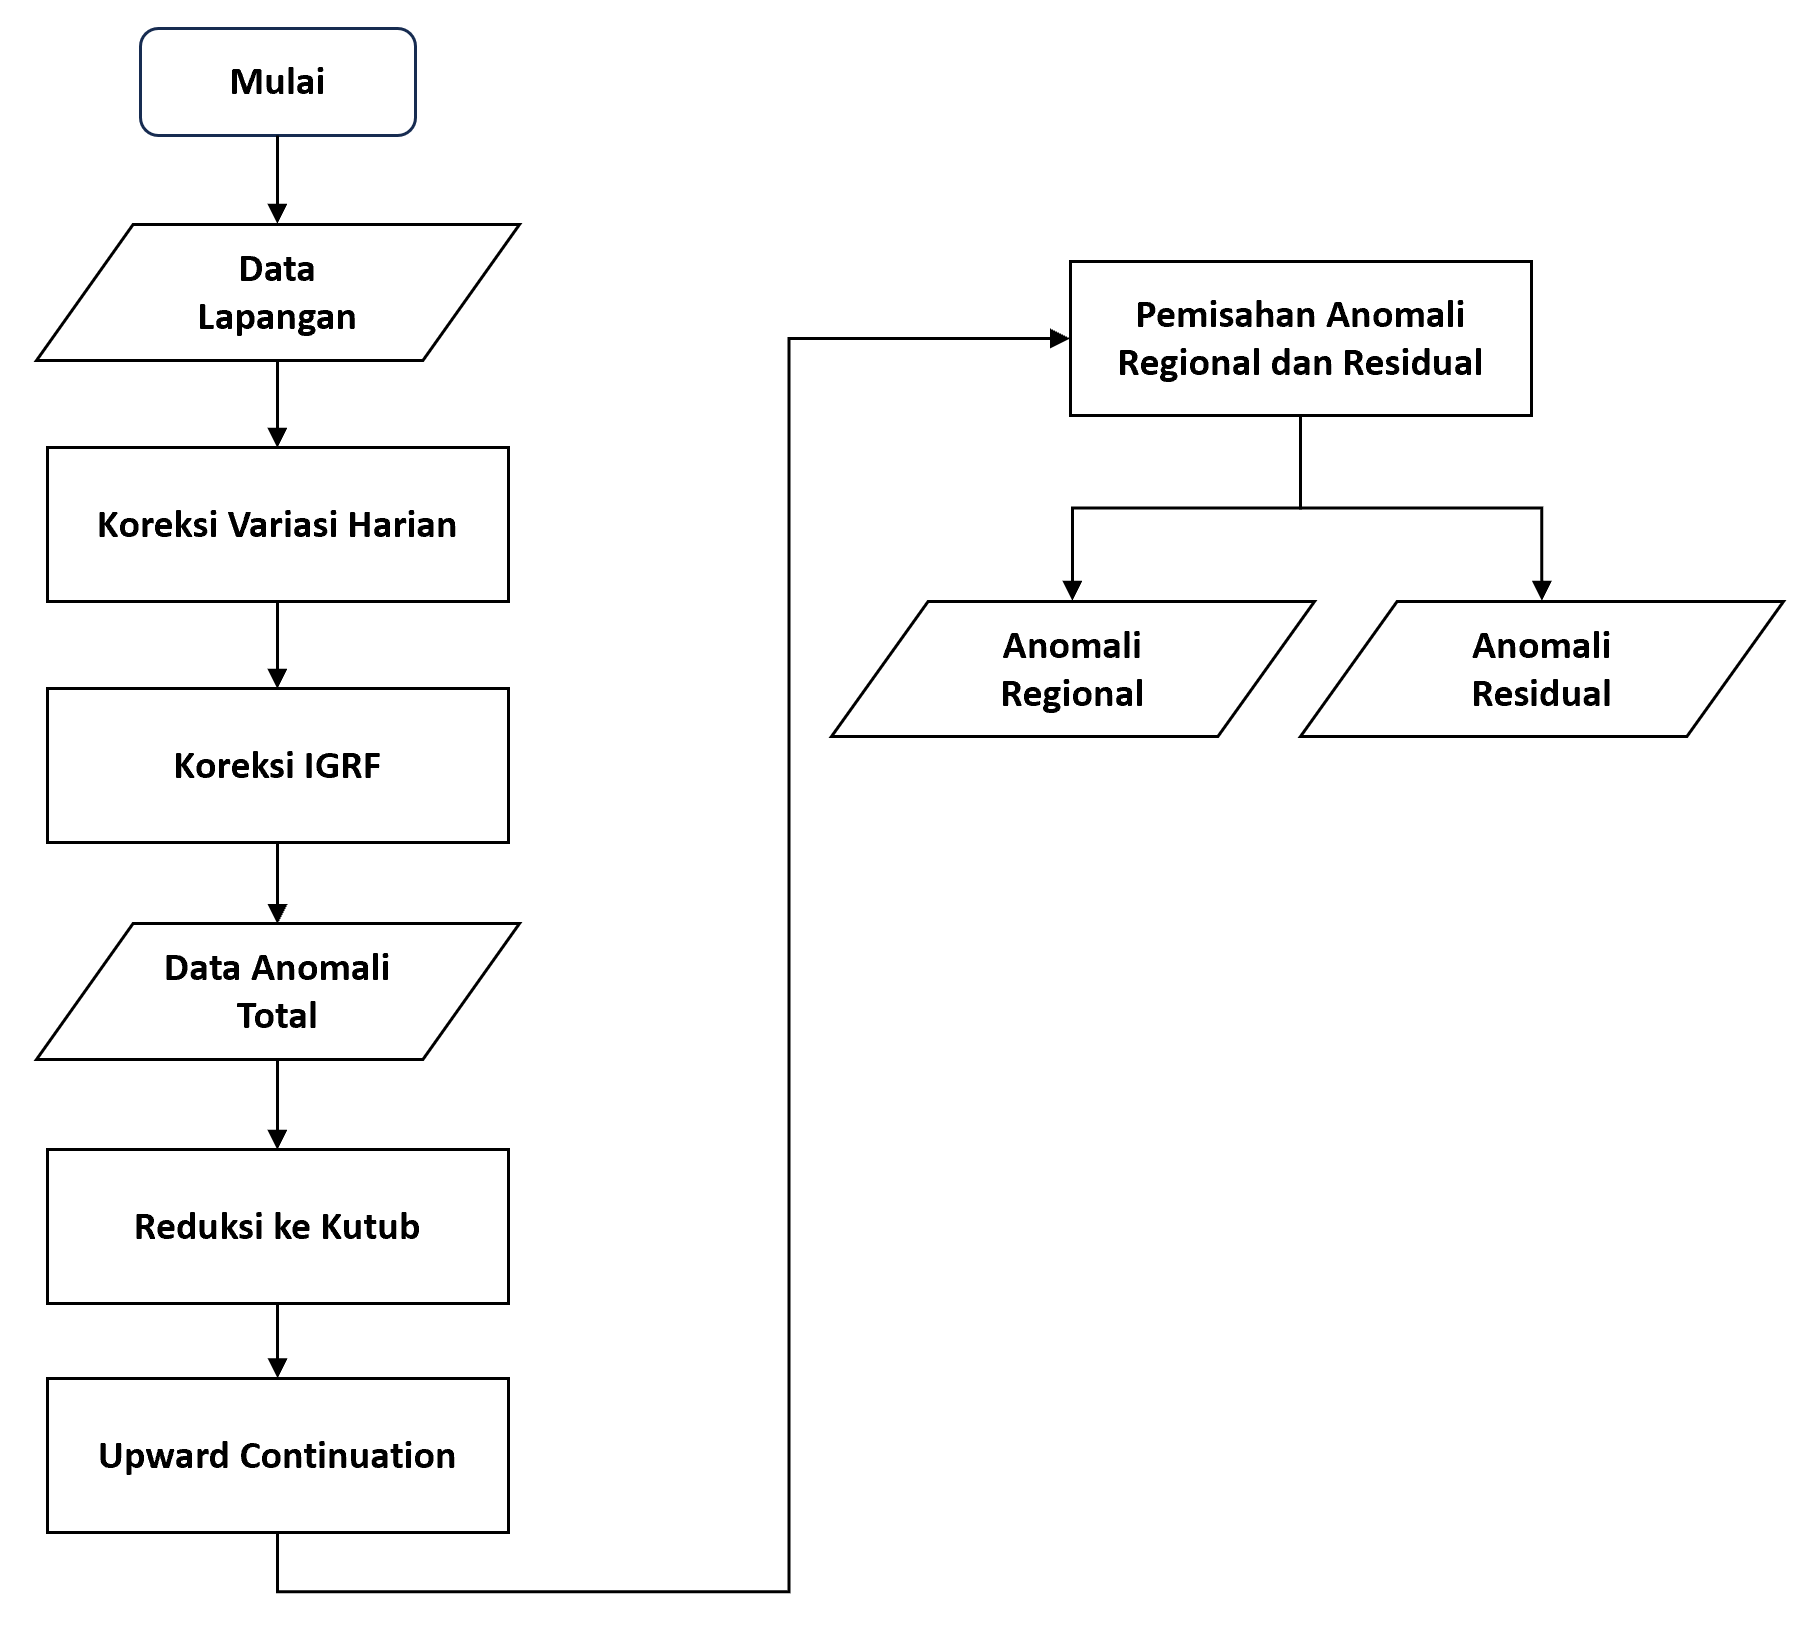

**1. Koreksi Diurnal**

Langkah pertama adalah melakukan koreksi variasi harian. Koreksi diurnal (diurnal correction) atau koreksi harian merupakan koreksi untuk menghilangkan efek dari penyimpangan nilai medan magnet bumi akibat adanya perbedaan waktu dan efek radiasi matahari dalam satu hari. Waktu yang dimaksudkan harus mengacu atau sesuai dengan waktu pengukuran data medan magnet di setiap titik lokasi (stasiun pengukuran) yang akan dikoreksi. Koreksi diurnal dapat dituliskan dalam persamaan:

ΔH = H TOTAL ± ΔH HARIAN

dimana ΔH adalah medan magnet terkoreksi, H TOTAL adalah medan magnet terukur oleh alat, dan ΔH HARIAN adalah nilai koreksi variasi harian.

Untuk menghitung nilai variasi diurnal, data proton base station dapat dikurangkan dengan nilai pertamanya.

In [ ]:
base1s['VH'] = base1s['Fbase_filt'] - base1s['Fbase_filt'][0]
base1s

Selanjutnya, untuk melakukan perhitungan koreksi diurnal, jam pengamatan pada proton base station disesuaikan dengan waktu rata-rata pembacaan proton hasil survey.

In [ ]:
data['VH'] = base1s.loc[data['Waktu_rata']].reset_index()['VH']
data

**2. Koreksi IGRF**

Data hasil pengukuran medan magnet pada dasarnya adalah konstribusi dari tiga komponen dasar, yaitu medan magnet utama bumi, medan magnet eksternal dan medan anomali. Nilai medan magnetik utama tidak lain adalah nilai IGRF (*International Geomagnetic Reference Field*). Jika nilai medan magnet utama dihilangkan dengan koreksi harian, maka kontribusi medan magnetik utama dihilangkan dengan koreksi IGRF. Koreksi IGRF dapat dilakukan dengan cara mengurangkan nilai IGRF terhadap nilai medan magnet total yang telah terkoreksi harian pada setiap titik pengukuran pada posisi geografis yang sesuai. Persamaan koreksinya (setelah dikoreksi harian) dapat dituliskan sebagai berikut :

ΔH = H TOTAL ± ΔH HARIAN - H IGRF

dimana H IGRF adalah nilai IGRF

In [ ]:
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

IGRF = []
for i in range(len(data)):
    myProj = pyproj.Proj("+proj=utm +zone=48 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    lon_,lat_ = myProj(data['Longitude'].iloc[i], data['Latitude'].iloc[i], inverse=True)
    date = datetime.datetime.strptime(data['Waktu_rata'].iloc[i], '%Y-%m-%d %H:%M:%S')
    t = float('%.2f'%year_fraction(date))

    IGRF = IGRF + [pyIGRF.igrf_value(lat_, lon_, 0, t)[-1]]

data['IGRF'] = IGRF

data

Setelah itu, kita dapat menghitung nilai anomali medan magnet totalnya.

In [ ]:
data['anomali'] = data['F_rata'].astype(float) - data['VH'] - data['IGRF']
data

Untuk membuat peta kontur anomali medan magnet totalnya, data harus kita interpolasi agar membentuk grid. Disini kita gunakan metode Spline untuk interpolasi data.

In [ ]:
spline = vd.Spline()
spline.fit((data['Longitude'], data['Latitude']), data['anomali'])
grid = spline.grid(region=(672480, 672850, 9225140, 9225530), spacing=1, dims=['northing', 'easting'], data_names='anomali')

Selanjutnya, kita buat peta kontur anomali medan magnet totalnya.

In [ ]:
fig = pygmt.Figure()
fig.basemap(projection='x1:2000', region=[672480, 672850, 9225140, 9225530], frame=True)
scale = 0.25 * vd.maxabs(grid.anomali)
pygmt.makecpt(cmap="seis+h", series=[-scale, scale], background=True)
fig.grdimage(grid=grid.anomali, cmap=True)
fig.grdcontour(grid=grid.anomali, interval=100, annotation=100)
fig.colorbar(frame=["x+lAnomali Medan Magnet Total (nT) "], cmap=True)
fig.show()

Agar peta terlihat lebih baik, area di luar titik pengukuran kita hilangkan atau di clip. Kita masukkan titik-titik batas area pengukuran.

In [ ]:
CRS = pyproj.crs.CRS('+proj=utm +zone=48 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [672613.31, 9225522.86],
            [672837.03, 9225294.03],
            [672670.00, 9225150.50],
            [672633.74, 9225187.78],
            [672629.14, 9225248.06],
            [672492.76, 9225406.40],
            [672613.31, 9225522.86],
        ]],
    }
]


# Clipping data anomali total
grid.rio.set_spatial_dims("easting", "northing", inplace=True)
grid.rio.write_crs(CRS, inplace=True)
clipped_total = grid.rio.clip(geometries)
clipped_total.max(skipna=True)
clipped_total

Kita tampilkan peta kontur anomali medan magnet total yang sudah di clip

In [ ]:
# Menampilkan Peta Anomali Medan Magnet Total
fig = pygmt.Figure()
fig.basemap(projection='x1:2000', region=[672480, 672850, 9225140, 9225530], frame=["WSen+tPeta Anomali Medan Magnet Total", "af"])
scale = 0.25 * vd.maxabs(grid.anomali)
pygmt.makecpt(cmap="seis+h", series=[-scale, scale], background=True)
fig.grdimage(grid=clipped_total.anomali, cmap=True, nan_transparent=True)
fig.grdcontour(grid=clipped_total.anomali, interval=100, annotation=100)
fig.colorbar(frame=["x+lAnomali Total (nT)"], cmap=True, position="JBC+h+o0/1c+e")
fig.show()
print(' ')

**Referensi**



> Arifin, Y. I. (2019). Kemagnetan Batuan (Anisotropi Batuan Beku). UNG Press Gorontalo.

> Constable, C.G., and Constable, S.C., (2004). Satellite magnetic field measurements: applications in studying the deep earth. In Sparks, R.S.J., and Hawkesworth, C.J., (eds.), The State of the Planet: Frontiers and Challenges in Geophysics. Washington, DC: American Geophysical Union, doi: 10.1029/150GM13, pp. 147–160.

> Fenoglio, M. A., Johnston, M.J.S., dan Byerlee, J.D. (1995). Magnetic and Electric Fields Associated with Changes in High Pore Pressure in Fault Zone-Application to the Loma Prieta ULF Emissions, J. Geophys. Res. 100, pp 12951-12958.

> Freund, F.T. (2007). Pre-Earthquake Signals-Part I: Deviatoric Stresses Turn Rocks into A Source of Electric Currents, Natural Hazards Earth System Science, pp 535-541.

> Hattori, K. (2004). ULF geomagnetic changes associated with large earthquakes, Terr. Atmos. OceanSci., vol. 15,no. 3, pp. 329–360.

> Ismaguilov, V. S., Kopytenko, Yu. A., Hattori, K., and Hayakawa, M. (2003). Variations of phase velocity and gradient values of ULF geomagnetic disturbances connected with the Izu strong earthquakes, Nat. Hazards Earth Syst. Sci., 3, 211–215, https://doi.org/10.5194/nhess-3-211-2003.

> Kolhatkar, A., Jamison, A., Litvinov, D., Willson, R., & Lee, T. (2013). Tuning the Magnetic Properties of Nanoparticles. International Journal of Molecular Sciences, 14(8), 15977–16009. MDPI AG. Retrieved from http://dx.doi.org/10.3390/ijms14081597

> Kopytenko, Y. & Ismagilov, V. & Hayakawa, Masashi & Smirnova, N. & Troyan, V. & Peterson, T.. (2001). Investigation of the ULF electromagnetic phenomena related to earthquakes: Contemporary achievements and the perspectives. Annali di Geofisica. 44. 325-334.

> Merzer, M., dan Klemperer, S.L. (1997). Modelling Low-Frequency Magnetik Field Prekursors to the Loma Prieta Earthquake with A Prekursory Increase in Fault Zone Conductivity, Pure Applied Geophysics, Vol. 150, pp 217-248.

> Molchanov, O.A., dan Hayakawa, M. (1998). On the Generation Mechanism of ULF Seismogenic Emissions, Physics Earth Planet International, Vol. 105, pp 210-210.

> Nettleton, L. L. (1962). Gravity and Magnetics for Geologists and Seismologists. AAPG Bulletin, Vol. 46, No. 10, pp. 1815-1838

> Ravat, D. (2007). Reduction to Pole. In: Gubbins, D., Herrero-Bervera, E. (eds) Encyclopedia of Geomagnetism and Paleomagnetism. Springer, Dordrecht. https://doi.org/10.1007/978-1-4020-4423-6_275

> Santosa, Bagus J., Mashuri, Sutrisno, Wahyu T., Wafi, A., Salim, R., dan Armi, R. (2012). Interpretasi Metode Magnetik untuk Penentuan Struktur Bawah Permukaan di Sekitar Gunung Kelud Kabupaten Kediri. Jurnal Penelitian Fisika dan Aplikasinya (JPFA), Vol. 2 No. 1, Juni 2012. ISSN: 2087-9946.

> Uieda, L., V. C. Oliveira Jr, and V. C. F. Barbosa (2013), Modeling the Earth with Fatiando a Terra, Proceedings of the 12th Python in Science Conference, pp. 91-98. doi:10.25080/Majora-8b375195-010

> Uieda, L., Tian, D., Leong, W. J., Schlitzer, W., Grund, M., Jones, M., Fröhlich, Y., Toney, L., Yao, J., Magen, Y., Tong, JH., Materna, K., Belem, A., Newton, T., Anant, A., Ziebarth, M., Quinn, J., and Wessel, P. (2023). PyGMT: A Python interface for the Generic Mapping Tools (Version 0.9.0). doi:10.5281/zenodo.7772533

